In [81]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import re
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import seaborn as sns
from scipy import stats

In [82]:
pd.set_option('display.float_format', '{:,.2f}'.format)


In [83]:
df = pd.read_csv('Cars Datasets 2025.csv', encoding='latin-1')
df.head(50)

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm
5,BMW,Mclaren 720s,V8,"3,994 cc",710 hp,341 km/h,2.9 sec,"$499,000",Petrol,2,770 Nm
6,ASTON MARTIN,VANTAGE F1,V8,"3,982 cc",656 hp,314 km/h,3.6 sec,"$193,440",Petrol,2,685 Nm
7,BENTLEY,Continental GT Azure,V8,"3,996 cc",550 hp,318 km/h,4.0 sec,"$311,000",Petrol,4,900 Nm
8,LAMBORGHINI,VENENO ROADSTER,V12,"6,498 cc",750 hp,356 km/h,2.9 sec,"$4,500,000",Petrol,2,690 Nm
9,FERRARI,F8 TRIBUTO,V8,"3,900 cc",710 hp,340 km/h,2.9 sec,"$280,000",Petrol,2,770 Nm


In [84]:
df_cleaned = df.copy()

euro_to_usd = 1.1

def clean_price(price):
    if pd.isna(price):
        return None

    price_str = str(price).strip()

    price_str = price_str.replace("Math input error", "").strip()

    price_str = price_str.replace("–", "-").replace("—", "-")

    if "€" in price_str:
        match = re.search(r"€\s*([\d,]+)", price_str)
        if match:
            value = int(match.group(1).replace(",", ""))
            return round(value * euro_to_usd)

    range_match = re.match(r"([\d,]+)\s*-\s*([\d,]+)", price_str)
    if range_match:
        low = int(range_match.group(1).replace(",", ""))
        high = int(range_match.group(2).replace(",", ""))
        return (low + high) // 2

    num_match = re.search(r"([\d,]+)", price_str)
    if num_match:
        return int(num_match.group(1).replace(",", ""))

    return None

df_cleaned["Cars Prices"] = df_cleaned["Cars Prices"].apply(clean_price)

df_cleaned.rename(columns={"Cars Prices": "Cars Prices (USD)"}, inplace=True)

In [85]:
df_cleaned["Fuel Types"] = df_cleaned["Fuel Types"].str.replace("hyrbrid", "hybrid", case=False)

In [86]:
df_cleaned

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices (USD),Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"1,100,000.00",plug in hybrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"460,000.00",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"12,000.00",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"161,000.00",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"253,290.00",Petrol,2,560 Nm
...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487 cc,240 hp,180 km/h,7.6 sec,"43,590.00",Hybrid (Gas + Electric),5,239 Nm
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393 cc + Battery,326 hp,180 km/h,6.8 sec,"50,000.00",Hybrid,7,630 Nm
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987 cc / Hybrid batt,169  196 hp,190 km/h,8.0  9.2 sec,"25,210.00",Gas / Hybrid,5,190  210 Nm
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798 / 1987 cc + batt,140  198 hp,180 km/h,7.9  10.5 sec,"33,000.00",Hybrid,5,190  205 Nm


In [87]:
hybrid_electric_cars = df_cleaned[
    df_cleaned["Fuel Types"].str.contains("hybrid|electric", case=False, na=False)
].copy()

hybrid_electric_cars["Fuel Types"] = hybrid_electric_cars["Fuel Types"].str.lower()

hybrid_electric_cars["Fuel Types"] = hybrid_electric_cars["Fuel Types"].apply(
    lambda x: "Hybrid" if "hybrid" in x else "Electric"
)

hybrid_electric_cars[["Cars Names", "Cars Prices (USD)", "Fuel Types"]]

,Cars Names,Cars Prices (USD),Fuel Types
0,SF90 STRADALE,"1,100,000.00",Hybrid
32,VALKYRIE,"3,200,000.00",Hybrid
33,VALHALLA,"1,100,000.00",Hybrid
42,SIAN,"2,800,000.00",Hybrid
97,BENZ EQS 53,"102,000.00",Electric
...,...,...,...
1213,Crown Signia,"43,590.00",Hybrid
1214,4Runner (6th Gen),"50,000.00",Hybrid
1215,Corolla Cross,"25,210.00",Hybrid
1216,C-HR+,"33,000.00",Hybrid


In [88]:
hybrid_electric_cars.describe()

,Cars Prices (USD)
count,210.00
mean,"101,957.24"
std,"307,792.34"
min,"11,000.00"
25%,"35,000.00"
50%,"47,745.00"
75%,"85,000.00"
max,"3,200,000.00"


In [89]:
hybrid_cars = df_cleaned[df_cleaned["Fuel Types"].str.contains("hybrid", case=False, na=False)]

hybrid_cars[["Cars Names", "Cars Prices (USD)", "Fuel Types"]]

,Cars Names,Cars Prices (USD),Fuel Types
0,SF90 STRADALE,"1,100,000.00",plug in hybrid
32,VALKYRIE,"3,200,000.00",Hybrid
33,VALHALLA,"1,100,000.00",Hybrid
42,SIAN,"2,800,000.00",Hybrid
142,I8 ROADSTER,"165,000.00",Hybrid
...,...,...,...
1213,Crown Signia,"43,590.00",Hybrid (Gas + Electric)
1214,4Runner (6th Gen),"50,000.00",Hybrid
1215,Corolla Cross,"25,210.00",Gas / Hybrid
1216,C-HR+,"33,000.00",Hybrid


In [90]:
df_cleaned["Fuel Types"].unique()

array(['plug in hybrid', 'Petrol', 'Diesel', 'Hybrid', 'Electric',
       'Petrol/Diesel', 'Plug-in Hybrid', 'Petrol/AWD', 'Petrol/Hybrid',
       'Hydrogen', 'Diesel/Petrol', 'Petrol/EV', 'Hybrid/Electric',
       'Petrol, Hybrid', 'Petrol, Diesel', 'Hybrid (Petrol)',
       'CNG/Petrol', 'Hybrid/Petrol', 'Diesel Hybrid', 'Petrol (Hybrid)',
       'Hybrid (Gas + Electric)', 'Gas / Hybrid', 'Hybrid / Plug-in'],
      dtype=object)

In [91]:
fuel_col = df_cleaned["Fuel Types"].str.lower().fillna("")

is_petrol_or_gas = fuel_col.str.contains("petrol") | fuel_col.str.contains("gas")

not_mixed = ~fuel_col.str.contains("hybrid|electric|plug")

pure_gas_mask = is_petrol_or_gas & not_mixed

gas_cars = df_cleaned[pure_gas_mask].copy()

gas_cars["Fuel Types"] = "Gas"

In [92]:
gas_cars[["Cars Names", "Cars Prices (USD)", "Fuel Types"]]

,Cars Names,Cars Prices (USD),Fuel Types
1,PHANTOM,"460,000.00",Gas
2,KA+,"12,000.00",Gas
3,GT 63 S,"161,000.00",Gas
4,AUDI R8 Gt,"253,290.00",Gas
5,Mclaren 720s,"499,000.00",Gas
...,...,...,...
1208,Bongo Truck,"15,000.00",Gas
1209,Rotary Pickup,"18,000.00",Gas
1210,Luce Rotary Coupe,"25,000.00",Gas
1211,Millenia S,"30,000.00",Gas


In [93]:
gas_cars.describe()

,Cars Prices (USD)
count,898.00
mean,"156,397.85"
std,"806,000.36"
min,"4,000.00"
25%,"25,417.50"
50%,"41,640.00"
75%,"72,150.00"
max,"18,000,000.00"


In [94]:
group1 = gas_cars[gas_cars['Fuel Types'] == 'Gas']['Cars Prices (USD)'].dropna()
group2 = hybrid_electric_cars[hybrid_electric_cars['Fuel Types'].isin(['Hybrid', 'Electric'])]['Cars Prices (USD)'].dropna()
t_stat, p_val_two_sided = ttest_ind(group1, group2, equal_var=False)

if t_stat > 0:
    p_val_one_sided = p_val_two_sided / 2
else:
    p_val_one_sided = 1 - (p_val_two_sided / 2)

print("t-statistic:", t_stat)
print("One-sided p-value (Hybrid > Gas):", p_val_one_sided)


t-statistic: 1.5884997804993128
One-sided p-value (Hybrid > Gas): 0.0562650808770835


# # Since p-value is greater than alpha we fail to reject the null hypothesis at 0.05 significance level. There is no statistically significant difference in the average prices of gas cars and hybrid cars in your dataset. The observed difference in means could just be due to random chance.


In [95]:
gas_copy = gas_cars.copy()
hybrid_copy = hybrid_electric_cars.copy() 

def clean_price(price_str):
    if pd.isna(price_str):
        return None
    return float(str(price_str).replace(',', '').strip())

gas_copy['Cleaned Price'] = gas_copy['Cars Prices (USD)'].apply(clean_price)
hybrid_copy['Cleaned Price'] = hybrid_copy['Cars Prices (USD)'].apply(clean_price)


gas_copy['Fuel Group'] = 'Gas'
hybrid_copy['Fuel Group'] = 'Hybrid/Electric' 

plot_df = pd.concat(
    [gas_copy[['Cleaned Price', 'Fuel Group']], hybrid_copy[['Cleaned Price', 'Fuel Group']]],
    ignore_index=True
)

plot_df = plot_df.dropna(subset=['Cleaned Price'])

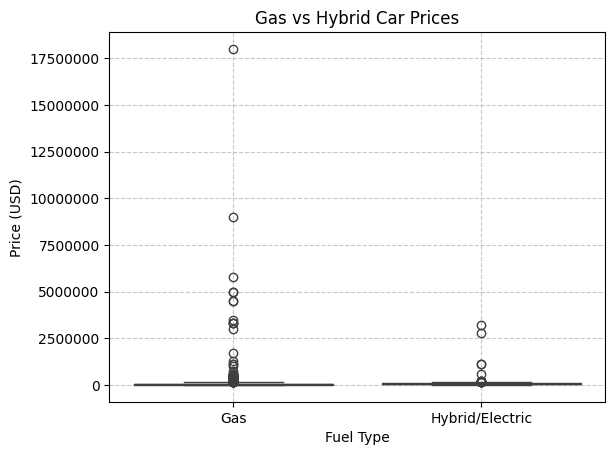

In [96]:
plt.ticklabel_format(style='plain', axis='y') 
sns.boxplot(x='Fuel Group', y='Cleaned Price', data=plot_df)
plt.title('Gas vs Hybrid Car Prices')
plt.ylabel('Price (USD)')
plt.xlabel('Fuel Type')


plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()



plt.show()

In [98]:
def clean_torque(val):
    if pd.isna(val):
        return None
    
    
    val = str(val).replace("Nm", "").strip()
    
    val = re.sub(r"[–\-]", "-", val)  
    numbers = re.findall(r"\d+", val)
    
    numbers = [int(n) for n in numbers]
    
    if len(numbers) == 1:
        return numbers[0]
    elif len(numbers) >= 2:
        return sum(numbers[:2]) / 2  
    else:
        return None


hybrid_electric_cars["Torque (Nm)"] = hybrid_electric_cars["Torque"].apply(clean_torque)

hybrid_electric_cars = hybrid_electric_cars.drop(columns=["Torque"])

In [99]:
def clean_torque(val):
    if pd.isna(val):
        return None
    
    val = str(val).replace("Nm", "").strip()
    val = re.sub(r"[–\-]", "-", val)  
    numbers = re.findall(r"\d+", val)
    numbers = [int(n) for n in numbers]

    if len(numbers) == 1:
        return numbers[0]
    elif len(numbers) >= 2:
        return sum(numbers[:2]) / 2  
    else:
        return None

gas_cars["Torque (Nm)"] = gas_cars["Torque"].apply(clean_torque)

gas_cars = gas_cars.drop(columns=["Torque"])

In [100]:
gas_cars[["Cars Names", "Torque (Nm)"]]

,Cars Names,Torque (Nm)
1,PHANTOM,900.00
2,KA+,120.00
3,GT 63 S,900.00
4,AUDI R8 Gt,560.00
5,Mclaren 720s,770.00
...,...,...
1208,Bongo Truck,150.00
1209,Rotary Pickup,160.00
1210,Luce Rotary Coupe,180.00
1211,Millenia S,250.00


In [101]:
gas_cars.describe()

,Cars Prices (USD),Torque (Nm)
count,898.00,898.00
mean,"156,397.85",411.55
std,"806,000.36",242.04
min,"4,000.00",45.00
25%,"25,417.50",237.00
50%,"41,640.00",366.00
75%,"72,150.00",550.00
max,"18,000,000.00","1,600.00"


In [104]:
hybrid_electric_cars[["Cars Names", "Torque (Nm)"]]

,Cars Names,Torque (Nm)
0,SF90 STRADALE,800.00
32,VALKYRIE,900.00
33,VALHALLA,"1,000.00"
42,SIAN,720.00
97,BENZ EQS 53,950.00
...,...,...
1213,Crown Signia,239.00
1214,4Runner (6th Gen),630.00
1215,Corolla Cross,200.00
1216,C-HR+,197.50


In [105]:
hybrid_electric_cars.describe()

,Cars Prices (USD),Torque (Nm)
count,210.00,210.00
mean,"101,957.24",441.01
std,"307,792.34",227.13
min,"11,000.00",5.00
25%,"35,000.00",270.25
50%,"47,745.00",352.00
75%,"85,000.00",600.00
max,"3,200,000.00","1,051.00"


In [120]:
gas_torque = gas_cars['Torque (Nm)'].dropna()
gas_fuel_type = ['Gas'] * len(gas_torque)

hybrid_torque = hybrid_electric_cars['Torque (Nm)'].dropna()
hybrid_fuel_type = ['Hybrid/Electric'] * len(hybrid_torque)

# Create separate DataFrames
gas_torque_df = pd.DataFrame({
    'Fuel Type': gas_fuel_type,
    'Torque (Nm)': gas_torque.values
})

hybrid_torque_df = pd.DataFrame({
    'Fuel Type': hybrid_fuel_type,
    'Torque (Nm)': hybrid_torque.values
})

In [121]:
combined_df = pd.DataFrame({
    'Fuel Type': gas_fuel_type + hybrid_fuel_type,
    'Torque (Nm)': np.concatenate([gas_torque.values, hybrid_torque.values])
})

In [122]:
group_stats = combined_df.groupby('Fuel Type')['Torque (Nm)'].agg(
    mean_torque='mean',
    sem_torque=lambda x: x.sem(), 
    count='count'
)


In [123]:
group_stats['ci_lower'] = group_stats['mean_torque'] - 1.96 * group_stats['sem_torque']
group_stats['ci_upper'] = group_stats['mean_torque'] + 1.96 * group_stats['sem_torque']

print("Group Statistics:")
print(group_stats)
print("\n" + "="*30 + "\n")


Group Statistics:
                 mean_torque  sem_torque  count  ci_lower  ci_upper
Fuel Type                                                          
Gas                   411.55        8.08    898    395.72    427.38
Hybrid/Electric       441.01       15.67    210    410.29    471.73




In [124]:
torque_gas = combined_df[combined_df['Fuel Type'] == 'Gas']['Torque (Nm)']
torque_hybrid = combined_df[combined_df['Fuel Type'] == 'Hybrid/Electric']['Torque (Nm)']

In [129]:
from scipy import stats

# Run the two-sample t-test (still gives a two-sided p-value)
t_stat, p_value_two_sided = stats.ttest_ind(torque_hybrid, torque_gas, equal_var=False)

# Adjust for one-sided test: Hₐ: μ_hybrid > μ_gas
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - (p_value_two_sided / 2)

print("One-Sided Independent T-Test (Hybrid/Electric > Gas):")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  One-sided P-value: {p_value_one_sided:.4f}")

alpha = 0.05
if p_value_one_sided < alpha:
    print(f"  Result: Reject the null hypothesis (p < {alpha}). The average torque of Hybrid/Electric cars is significantly greater than that of Gas cars.")
else:
    print(f"  Result: Fail to reject the null hypothesis (p ≥ {alpha}). No significant evidence that Hybrid/Electric cars have greater average torque than Gas cars.")


One-Sided Independent T-Test (Hybrid/Electric > Gas):
  T-statistic: 1.671
  One-sided P-value: 0.0479
  Result: Reject the null hypothesis (p < 0.05). The average torque of Hybrid/Electric cars is significantly greater than that of Gas cars.


In [130]:
group_stats = combined_df.groupby('Fuel Type')['Torque (Nm)'].agg(
    mean_torque='mean',
    sem_torque=lambda x: x.std(ddof=1) / len(x)**0.5
)

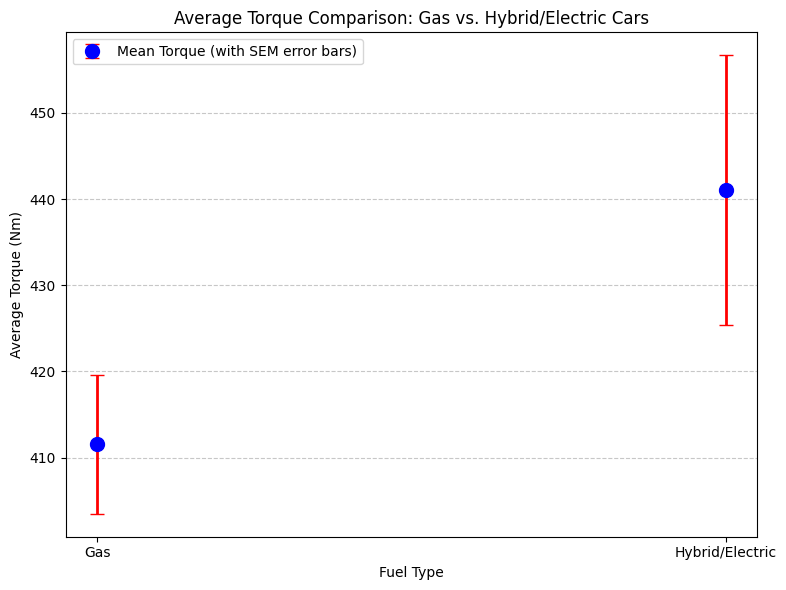

In [131]:
plt.figure(figsize=(8, 6))

plt.errorbar(
    x=group_stats.index,
    y=group_stats['mean_torque'],
    yerr=group_stats['sem_torque'], 
    fmt='o', 
    capsize=5, 
    color='blue',
    ecolor='red', 
    elinewidth=2, 
    markersize=10, 
    label='Mean Torque (with SEM error bars)'
)

plt.title('Average Torque Comparison: Gas vs. Hybrid/Electric Cars')
plt.xlabel('Fuel Type')
plt.ylabel('Average Torque (Nm)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
hybrid_electric_cars

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance_kmh,Cars Prices (USD),Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"1,100,000.00",Hybrid,2,800 Nm
32,ASTON MARTIN,VALKYRIE,V12,"6,496 cc",1160 hp,402 km/h,2.5 sec,"3,200,000.00",Hybrid,2,900 Nm
33,ASTON MARTIN,VALHALLA,V8,"3,996 cc",1000 hp,362 km/h,2.5 sec,"1,100,000.00",Hybrid,2,1000 Nm
42,LAMBORGHINI,SIAN,V12,"6,498 cc",819 hp,350 km/h,2.8 sec,"2,800,000.00",Hybrid,2,720 Nm
97,MERCEDES,BENZ EQS 53,ELECTRIC MOTOR,NaN,751 hp,250 km/h,3.4 sec,"102,000.00",Electric,5,950 Nm
...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487 cc,240 hp,180 km/h,7.6 sec,"43,590.00",Hybrid,5,239 Nm
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393 cc + Battery,326 hp,180 km/h,6.8 sec,"50,000.00",Hybrid,7,630 Nm
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987 cc / Hybrid batt,169  196 hp,190 km/h,8.0  9.2 sec,"25,210.00",Hybrid,5,190  210 Nm
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798 / 1987 cc + batt,140  198 hp,180 km/h,7.9  10.5 sec,"33,000.00",Hybrid,5,190  205 Nm


In [31]:
print(hybrid_cars.columns.tolist())


['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices (USD)', 'Fuel Types', 'Seats', 'Torque']


In [32]:
hybrid_electric_cars = hybrid_electric_cars.rename(columns={"Performance(0 - 100 )KM/H": "Performance_kmh"})

In [34]:
def clean_and_convert(performance_str):
    if pd.isna(performance_str):
        return None

    normalized = str(performance_str)
    normalized = re.sub(r'[–—‑−]', '-', normalized)
    normalized = normalized.replace('to', '-')

    numbers = re.findall(r'\d+\.?\d*', normalized)

    if len(numbers) == 2:
        avg_kmh = (float(numbers[0]) + float(numbers[1])) / 2
    elif len(numbers) == 1:
        avg_kmh = float(numbers[0])
    else:
        return None

    return avg_kmh / 1.036

In [35]:
hybrid_electric_cars["Performance (0 - 60 MPH)"] = hybrid_electric_cars["Performance_kmh"].apply(clean_and_convert)


In [36]:
hybrid_electric_cars

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance_kmh,Cars Prices (USD),Fuel Types,Seats,Torque,Performance (0 - 60 MPH)
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"1,100,000.00",Hybrid,2,800 Nm,2.41
32,ASTON MARTIN,VALKYRIE,V12,"6,496 cc",1160 hp,402 km/h,2.5 sec,"3,200,000.00",Hybrid,2,900 Nm,2.41
33,ASTON MARTIN,VALHALLA,V8,"3,996 cc",1000 hp,362 km/h,2.5 sec,"1,100,000.00",Hybrid,2,1000 Nm,2.41
42,LAMBORGHINI,SIAN,V12,"6,498 cc",819 hp,350 km/h,2.8 sec,"2,800,000.00",Hybrid,2,720 Nm,2.70
97,MERCEDES,BENZ EQS 53,ELECTRIC MOTOR,NaN,751 hp,250 km/h,3.4 sec,"102,000.00",Electric,5,950 Nm,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487 cc,240 hp,180 km/h,7.6 sec,"43,590.00",Hybrid,5,239 Nm,7.34
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393 cc + Battery,326 hp,180 km/h,6.8 sec,"50,000.00",Hybrid,7,630 Nm,6.56
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987 cc / Hybrid batt,169  196 hp,190 km/h,8.0  9.2 sec,"25,210.00",Hybrid,5,190  210 Nm,8.30
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798 / 1987 cc + batt,140  198 hp,180 km/h,7.9  10.5 sec,"33,000.00",Hybrid,5,190  205 Nm,8.88


In [50]:
styled_electric_hybrid_df = hybrid_electric_cars[["Company Names", "Fuel Types", "Cars Names", "Performance (0 - 60 MPH)"]] # Add all columns you want to see
styled_selected_columns = styled_electric_hybrid_df.style.format({"Performance (0 - 60 MPH)": '{:.4f}'})

In [54]:
styled_selected_columns

,Company Names,Fuel Types,Cars Names,Performance (0 - 60 MPH)
0,FERRARI,Hybrid,SF90 STRADALE,2.4131
32,ASTON MARTIN,Hybrid,VALKYRIE,2.4131
33,ASTON MARTIN,Hybrid,VALHALLA,2.4131
42,LAMBORGHINI,Hybrid,SIAN,2.7027
97,MERCEDES,Electric,BENZ EQS 53,3.2819
139,AUDI,Electric,E-TRON,5.3089
140,AUDI,Electric,E-TRON SPORTBACK,5.3089
142,BMW,Hybrid,I8 ROADSTER,4.2471
183,KIA,Hybrid,SPORTAGE PHEV,7.7220
190,KIA,Hybrid,SPORTAGE 2024(HYBRID AWD),7.7220


In [58]:
condition_fast_electric_hybrid_cars = hybrid_electric_cars["Performance (0 - 60 MPH)"] < 5
fast_electric_hybrid_cars_df = hybrid_electric_cars[condition_fast_hybrid_cars].copy()

In [60]:
fast_electric_hybrid_cars_df

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance_kmh,Cars Prices (USD),Fuel Types,Seats,Torque,Performance (0 - 60 MPH)
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"1,100,000.00",Hybrid,2,800 Nm,2.41
32,ASTON MARTIN,VALKYRIE,V12,"6,496 cc",1160 hp,402 km/h,2.5 sec,"3,200,000.00",Hybrid,2,900 Nm,2.41
33,ASTON MARTIN,VALHALLA,V8,"3,996 cc",1000 hp,362 km/h,2.5 sec,"1,100,000.00",Hybrid,2,1000 Nm,2.41
42,LAMBORGHINI,SIAN,V12,"6,498 cc",819 hp,350 km/h,2.8 sec,"2,800,000.00",Hybrid,2,720 Nm,2.70
97,MERCEDES,BENZ EQS 53,ELECTRIC MOTOR,NaN,751 hp,250 km/h,3.4 sec,"102,000.00",Electric,5,950 Nm,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...
958,Acura,NSX 3.5L Hybrid Coupe,Twin-Turbo V6 Hybrid,"3,493 cc",537 hp,307 km/h,2.9 sec,"157,000.00",Hybrid,2,666 Nm,2.80
961,Acura,NSX Carbon Edition,Twin-Turbo V6 Hybrid,"3,493 cc",537 hp,307 km/h,2.9 sec,"157,000.00",Hybrid,2,666 Nm,2.80
997,Peugeot,308 PSE,Hybrid I4,"1,598 cc (petrol) + Electric Motor",360 hp,250 km/h,5.0 sec,"55,000.00",Hybrid,5,520 Nm,4.83
1031,Ford,Mustang Mach-E,Electric Motor,Battery (68-98 kWh),290-480 hp,180 km/h,3.5 sec (GT Model),"43,000.00",Electric,5,430 Nm (GT Model),3.38


In [61]:
fast_electric_hybrid_cars_df.count()

Company Names               71
Cars Names                  71
Engines                     71
CC/Battery Capacity         70
HorsePower                  71
Total Speed                 71
Performance_kmh             71
Cars Prices (USD)           71
Fuel Types                  71
Seats                       71
Torque                      71
Performance (0 - 60 MPH)    71
dtype: int64

In [62]:
gas_cars

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices (USD),Fuel Types,Seats,Torque
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"460,000.00",Gas,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"12,000.00",Gas,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"161,000.00",Gas,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"253,290.00",Gas,2,560 Nm
5,BMW,Mclaren 720s,V8,"3,994 cc",710 hp,341 km/h,2.9 sec,"499,000.00",Gas,2,770 Nm
...,...,...,...,...,...,...,...,...,...,...,...
1208,Mazda,Bongo Truck,2.0L Inline-4,"1,998 cc",120 hp,130 km/h,15.0 sec,"15,000.00",Gas,2,150 Nm
1209,Mazda,Rotary Pickup,1.3L Wankel Rotary Engine,"1,308 cc",130 hp,150 km/h,14.5 sec,"18,000.00",Gas,2,160 Nm
1210,Mazda,Luce Rotary Coupe,1.3L Wankel Rotary Engine,"1,308 cc",135 hp,175 km/h,12.0 sec,"25,000.00",Gas,4,180 Nm
1211,Mazda,Millenia S,2.5L V6,"2,500 cc",200 hp,220 km/h,8.0 sec,"30,000.00",Gas,5,250 Nm


In [63]:
print(gas_cars.columns.tolist())


['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices (USD)', 'Fuel Types', 'Seats', 'Torque']


In [64]:
gas_cars = gas_cars.rename(columns={"Performance(0 - 100 )KM/H": "Performance_kmh"})

In [65]:
gas_cars["Performance (0 - 60 MPH)"] = gas_cars["Performance_kmh"].apply(clean_and_convert)


In [66]:
gas_cars

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance_kmh,Cars Prices (USD),Fuel Types,Seats,Torque,Performance (0 - 60 MPH)
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"460,000.00",Gas,5,900 Nm,5.12
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"12,000.00",Gas,5,100 - 140 Nm,10.14
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"161,000.00",Gas,4,900 Nm,3.09
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"253,290.00",Gas,2,560 Nm,3.47
5,BMW,Mclaren 720s,V8,"3,994 cc",710 hp,341 km/h,2.9 sec,"499,000.00",Gas,2,770 Nm,2.80
...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Mazda,Bongo Truck,2.0L Inline-4,"1,998 cc",120 hp,130 km/h,15.0 sec,"15,000.00",Gas,2,150 Nm,14.48
1209,Mazda,Rotary Pickup,1.3L Wankel Rotary Engine,"1,308 cc",130 hp,150 km/h,14.5 sec,"18,000.00",Gas,2,160 Nm,14.00
1210,Mazda,Luce Rotary Coupe,1.3L Wankel Rotary Engine,"1,308 cc",135 hp,175 km/h,12.0 sec,"25,000.00",Gas,4,180 Nm,11.58
1211,Mazda,Millenia S,2.5L V6,"2,500 cc",200 hp,220 km/h,8.0 sec,"30,000.00",Gas,5,250 Nm,7.72


In [67]:
styled_gas_df = gas_cars[["Company Names", "Fuel Types", "Cars Names", "Performance (0 - 60 MPH)"]] # Add all columns you want to see
styled_selected_columns_gas = styled_gas_df.style.format({"Performance (0 - 60 MPH)": '{:.4f}'})

In [68]:
styled_selected_columns_gas

,Company Names,Fuel Types,Cars Names,Performance (0 - 60 MPH)
1,ROLLS ROYCE,Gas,PHANTOM,5.1158
2,Ford,Gas,KA+,10.1351
3,MERCEDES,Gas,GT 63 S,3.0888
4,AUDI,Gas,AUDI R8 Gt,3.4749
5,BMW,Gas,Mclaren 720s,2.7992
6,ASTON MARTIN,Gas,VANTAGE F1,3.4749
7,BENTLEY,Gas,Continental GT Azure,3.8610
8,LAMBORGHINI,Gas,VENENO ROADSTER,2.7992
9,FERRARI,Gas,F8 TRIBUTO,2.7992
10,FERRARI,Gas,812 GTS,2.7992


In [69]:
condition_fast_gas_cars = styled_gas_df["Performance (0 - 60 MPH)"] < 5
fast_gas_cars_df = gas_cars[condition_fast_gas_cars].copy()

In [70]:
fast_gas_cars_df

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance_kmh,Cars Prices (USD),Fuel Types,Seats,Torque,Performance (0 - 60 MPH)
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"161,000.00",Gas,4,900 Nm,3.09
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"253,290.00",Gas,2,560 Nm,3.47
5,BMW,Mclaren 720s,V8,"3,994 cc",710 hp,341 km/h,2.9 sec,"499,000.00",Gas,2,770 Nm,2.80
6,ASTON MARTIN,VANTAGE F1,V8,"3,982 cc",656 hp,314 km/h,3.6 sec,"193,440.00",Gas,2,685 Nm,3.47
7,BENTLEY,Continental GT Azure,V8,"3,996 cc",550 hp,318 km/h,4.0 sec,"311,000.00",Gas,4,900 Nm,3.86
...,...,...,...,...,...,...,...,...,...,...,...,...
1050,Ford,Mustang Shelby GT500,Supercharged V8,"5,200 cc",760 hp,290 km/h,3.5 sec,"79,420.00",Gas,2,847 Nm,3.38
1051,Ford,Mustang Shelby GT350,Naturally Aspirated V8,"5,200 cc",526 hp,280 km/h,4.0 sec,"59,140.00",Gas,2,582 Nm,3.86
1062,Ford,Mustang (2024),V8 Gasoline Engine,"5,000 cc",450 hp,250 km/h,4.5 sec,"60,000.00",Gas,4,570 Nm,4.34
1076,Mitsubishi,Lancer Evolution X,2.0L Turbocharged,"2,000 cc",291 hp,240 km/h,5.0 sec,"40,000.00",Gas,5,407 Nm,4.83


In [71]:
fast_gas_cars_df.count()

Company Names               220
Cars Names                  220
Engines                     220
CC/Battery Capacity         220
HorsePower                  220
Total Speed                 220
Performance_kmh             220
Cars Prices (USD)           220
Fuel Types                  220
Seats                       220
Torque                      220
Performance (0 - 60 MPH)    220
dtype: int64

In [79]:
x1, n1 = 220, 898  # Gas_Cars
x2, n2 = 71, 211  # Hybrid_Electric_Cars


p1 = x1 / n1
p2 = x2 / n2

p_pool = (x1 + x2) / (n1 + n2)

se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

z = (p1 - p2) / se

p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"Z-statistic: {z:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: -2.7187
P-value: 0.0066


# # Since p-value = 0.0066 is less than any common alpha level (like 0.05 or 0.01), we reject the null hypothesis. There is a statistically significant difference in the proportion of high-performance vehicles between gas and hybrid/electric cars. Supports the idea that high performance is more common in EVs/hybrids.

In [76]:
data = {
    'Group': ['Gas Cars', 'Hybrid Cars'],
    'Successes': [220, 71],
    'Failures': [678, 140 ],   
    'Total': [898, 211]     
}
df = pd.DataFrame(data)


In [77]:
df['Prop_Success'] = df['Successes'] / df['Total']
df['Prop_Failure'] = df['Failures'] / df['Total']

print("DataFrame with Proportions:\n", df)


DataFrame with Proportions:
          Group  Successes  Failures  Total  Prop_Success  Prop_Failure
0     Gas Cars        220       678    898          0.24          0.76
1  Hybrid Cars         71       140    211          0.34          0.66


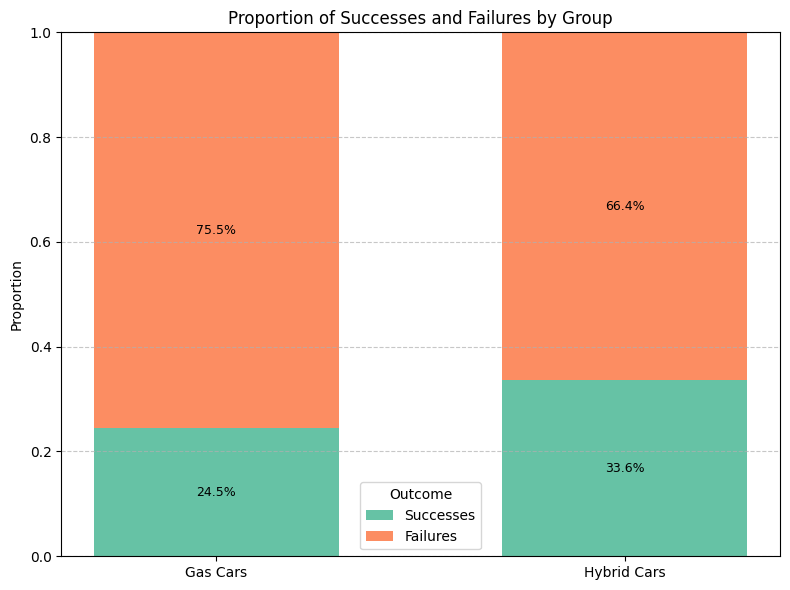

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6 # Adjust as needed

bars1 = ax.bar(df['Group'], df['Prop_Success'], bar_width, label='Successes', color='#66c2a5') # A nice green shade
bars2 = ax.bar(df['Group'], df['Prop_Failure'], bar_width, bottom=df['Prop_Success'], label='Failures', color='#fc8d62') # A nice orange shade

ax.set_ylabel('Proportion')
ax.set_title('Proportion of Successes and Failures by Group')
ax.set_ylim(0, 1) # Proportions always go from 0 to 1
ax.legend(title='Outcome')

def add_labels(bars, proportions, is_top=False):
    for bar, prop in zip(bars, proportions):
        yval = bar.get_height() / 2 + (bar.get_y() if is_top else 0) # Center the text
        ax.text(bar.get_x() + bar.get_width()/2, yval,
                f'{prop:.1%}', ha='center', va='center', color='black', fontsize=9)

add_labels(bars1, df['Prop_Success'])
add_labels(bars2, df['Prop_Failure'], is_top=True)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()